## Practical VDL class session for Hidden Markov Models: forward, Viterbi & Baum-Walch algorithms


In [237]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random as random
import pandas as pd
random.seed(42)

### Question 1 : simulation d’un HMM


In [248]:
def SimuHMMdisc(n, param):

    nu = np.array(param['pi'])
    B= np.array(param['B'])
    A= np.array(param['A']) 

    z = np.zeros(n, dtype=int)
    x = np.zeros(n, dtype=int)

    z[0] = np.random.choice(len(nu), p= nu) + 1
    x[0] = np.random.choice(len(B[z[0]]), p=B[z[0]])
 
    for i in range(1,n):
        z[i]= np.random.choice( len(nu), p=A[z[i-1]])
        x[i] = np.random.choice(len(B[z[i]]), p= B[z[i]])
  
    sequence = list(zip(x, z))
    
    return sequence 


In [249]:
n = int(10)

In [250]:
# Transition Matrix A for the hidden states
A = np.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# Emission Matrix B
# Rows correspond to hidden states, columns to observable outcomes
# B = np.transpose(np.array([
#     [1/6]*6 + [1/10]*5 + [0.5],
#     [1/6]*6 + [1/10]*5 + [0.5]
# ])).reshape(6, 2)
B = np.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],  # Uniform distribution over 6 outcomes for state 0
    [1/10, 1/10, 1/10, 1/10, 1/10, 0.5]  # Different distribution for state 1
])

eigenvalues, eigenvectors = np.linalg.eig(A.T)
pi_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
pi_real = np.real(pi_vector)
pi = pi_real / np.sum(pi_real)

param = {
    'A': A,
    'B': B,
    'pi': pi.flatten()  
}
param


{'A': array([[0.95, 0.05],
        [0.1 , 0.9 ]]),
 'B': array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
         0.5       ]]),
 'pi': array([0.66666667, 0.33333333])}

In [251]:
seq = SimuHMMdisc(n, param)
seq

[(4, 1),
 (5, 1),
 (3, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (2, 1),
 (3, 1),
 (5, 1),
 (0, 1)]

range(0, 10)


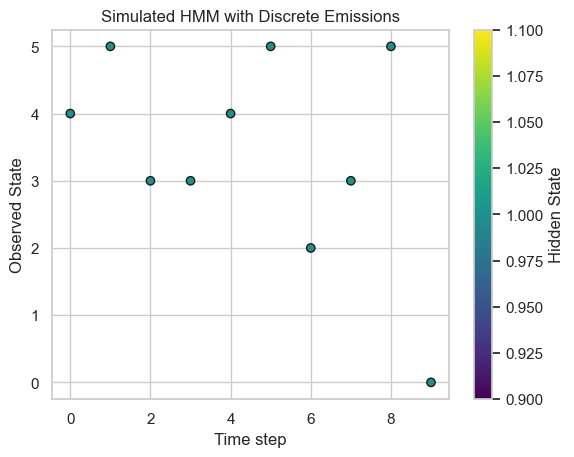

In [252]:
x, z = zip(*seq)
x, z = list(x), list(z)
plt.scatter(range(n), x, c=z, cmap='viridis', edgecolors='k')
print(range(n))
plt.colorbar(label='Hidden State')
plt.xlabel('Time step')
plt.ylabel('Observed State')
plt.title('Simulated HMM with Discrete Emissions')
plt.show()

### Question 2. calcul de la vraisemblance - l’algorithme forward


In [253]:
print(math.exp(-100001))

#avoid overflowing part
def log_sum_exp(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

log_sum_exp([-100000, -100001, -100002])

0.0


-99999.59239403556

In [254]:
# K = 4
# nexp = 100  
# mus = np.linspace(0, -1000, nexp) 
# res = pd.DataFrame({
#     'mu': mus,
#     'naive': np.nan,
#     'log_trick': np.nan
# })

# for i in range(len(mus)):
#     a = np.random.normal(loc=mus[i], scale=20, size=K)
#     res.loc[i, 'naive'] = np.log(np.sum(np.exp(a)))
#     res.loc[i, 'log_trick'] = log_sum_exp(a)

# df = res.melt(id_vars='mu', var_name='Method', value_name='logsumexp')


# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))
# ax = sns.scatterplot(data=df, x='mu', y='logsumexp', hue='Method', style='Method', s=100, alpha=0.7)
# plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], 'k--')  # y=x line
# plt.title('Illustration of the log-sum-exp trick')
# plt.show()



$$ \alpha_i(k) = P(observe \, sequence \, up \, until\,  time \, i \, and \, have \, hidden \, state \, at \, k)   $$ 
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K \alpha_{i-1}(l) \cdot A_{lk} \cdot \Psi_i(k) \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l) \cdot A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log(\Psi_i(k)) + \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \right)
$$

$$ init: \, \alpha_1(l) = p(x_1, z_1 = l) = \nu_l \Psi_1(l), \, \forall l$$

In [255]:
def forward(x, i, param):
    """return : log α_i s using log_trick"""
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_alpha = np.full((n, K), -np.inf)
    
    for l in range(K):
        log_alpha[0, l] = np.log(nu[l]) + np.log(B[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            # log_alpha_prev = np.log(log_alpha[i]) 
            exponent = log_alpha[i-1] + np.log(A[:,k])
            # print(log_alpha[i-1] )
            log_alpha[i, k] = np.log(psi[k, x[i]]) + log_sum_exp(exponent)



    # return log_alpha
    return log_alpha[i-1] 

In [256]:
logalpha_10 = forward(x, 10, param)
logalpha_10 # hidden state at time i is 2?!

array([-16.56119433, -16.71330161])

In [257]:
z[9]

1

Une fonction HMMloglik(x, param) qui calcule la log-vraisemblance de x sous un modèle HMM discret

In [ ]:
def HMMloglik(x, param):
    K= np.array(param['A']).shape[0]
    sum = 0
    for k in range(K):
        sum+= forward(x, k, param)
    return np.log(sum)

In [ ]:
def Viterbi(x, param):

    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    V = np.full((n, K), -np.inf)
    
    for l in range(K):
        V[0, l] = np.log(nu[l]) + np.log(B[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            V[i, k]= psi[k, x[i]]


    